# Churn Analysis - Dataset Employees

**Bogor, 28th September 2023**

---

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from imblearn.over_sampling import RandomOverSampler
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\aiforesee\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


***Churn Definition***

Data yang digunakan merupakan dataset pegawai yang resign. Dalam kasus ini churn didefinisikan sebagai pegawai yang **Voluntarily Terminated** dan **Terminated for Cause**

***Load Data***

In [3]:
# Load data csv
data = pd.read_csv("dataset_HR.csv")

data.head().T

,0,1,2,3,4
EmpID,10001,10002,10003,10004,10005
LevelID,Senior,Senior,Senior,Middle,Middle
PerfScoreID,Exceed,Fully meets,Average,Exceed,Average
EngagementSurvey,4.6,4.96,3.02,4.84,5.0
EmpSatisfaction,5,3,3,5,4
SpecialProjectsCount,0,6,0,0,0
DaysLateLast30,0,0,0,0,0
Absences,1,17,3,15,2
Age,38,46,32,32,31
Churn,0,1,1,0,1


In [4]:
# Cek data shape
data.shape

(287, 10)

In [5]:
# Cek EmpID yang duplikat
data['EmpID'].duplicated().sum()

0

In [6]:
# Drop EmpID
data = data.drop(columns=['EmpID'], axis=1)

# Cek nformasi
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LevelID               287 non-null    object 
 1   PerfScoreID           287 non-null    object 
 2   EngagementSurvey      287 non-null    float64
 3   EmpSatisfaction       287 non-null    int64  
 4   SpecialProjectsCount  287 non-null    int64  
 5   DaysLateLast30        287 non-null    int64  
 6   Absences              287 non-null    int64  
 7   Age                   287 non-null    int64  
 8   Churn                 287 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 20.3+ KB


In [7]:
# Cek proporsi variabel respon
data['Churn'].value_counts(normalize=True)

0    0.675958
1    0.324042
Name: Churn, dtype: float64

# Sample Splitting
---

In [8]:
response_variable = 'Churn'

# Split respon dan prediktor
y = data[response_variable]
X = data.drop(columns=[response_variable], axis=1)

print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (287,)
X shape : (287, 8)


In [9]:
# Split data train dan test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (200, 8)
y train shape : (200,)
X test shape  : (87, 8)
y test shape  : (87,)


In [10]:
y_train.value_counts(normalize=True)

0    0.675
1    0.325
Name: Churn, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.678161
1    0.321839
Name: Churn, dtype: float64

# Exploratory Data Analysis
---

In [13]:
# Concat X_train dan y_train sebagai data_train
data_train = pd.concat((X_train, y_train), axis=1)

print('Train data shape:', data_train.shape)
data_train.head().T

Train data shape: (200, 9)


,57,45,270,265,47
LevelID,Junior,Middle,Senior,Senior,Junior
PerfScoreID,Exceed,Exceed,Exceed,Average,Average
EngagementSurvey,3.04,3.0,4.1,4.1,3.58
EmpSatisfaction,3,5,4,4,5
SpecialProjectsCount,6,0,0,0,0
DaysLateLast30,0,0,0,0,0
Absences,2,17,18,16,3
Age,34,51,32,48,33
Churn,0,0,0,1,0


## Check for Missing Values

---

In [16]:
# Cek missing values
pd.DataFrame(data_train.isna().sum()).rename(columns = {0: 'missing value'})

,missing value
LevelID,0
PerfScoreID,0
EngagementSurvey,0
EmpSatisfaction,0
SpecialProjectsCount,0
DaysLateLast30,0
Absences,0
Age,0
Churn,0


In [13]:
# Cek tipe data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 57 to 174
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LevelID               200 non-null    object 
 1   PerfScoreID           200 non-null    object 
 2   EngagementSurvey      200 non-null    float64
 3   EmpSatisfaction       200 non-null    int64  
 4   SpecialProjectsCount  200 non-null    int64  
 5   DaysLateLast30        200 non-null    int64  
 6   Absences              200 non-null    int64  
 7   Age                   200 non-null    int64  
 8   Churn                 200 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 15.6+ KB


In [14]:
# Create a function of independence test
def independence_test(predictor_label, alpha=0.05):
    """
    Funtion to perform the independence test.

    Parameters
    ----------
    predictor_label : object
      The label of predictor variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    """
    # Build the contingency table
    crosstab = pd.crosstab(data_train[predictor_label],
                           data_train['Churn'],
                           margins = False)

    # Test whether churn is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        print(f"Churn and {predictor_label} is not independent with P-val={pval}.")
    else:
        print(f"Churn and {predictor_label} is independent with P-val={pval}.")

## Predictor 1: LevelID       

---
Level Pegawai

In [15]:
# Proporsi 'LevelID'
data_train['LevelID'].value_counts(normalize=True)

Junior    0.625
Middle    0.215
Senior    0.160
Name: LevelID, dtype: float64

<AxesSubplot:xlabel='LevelID', ylabel='count'>

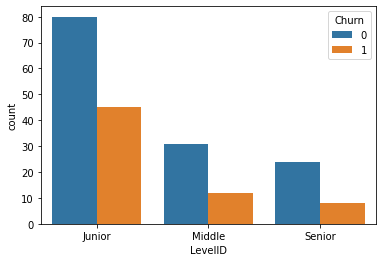

In [16]:
# Proporsi churn berdasarkan 'LevelID'
sns.countplot(data = data_train,
              x = 'LevelID',
              hue = 'Churn')

In [17]:
# Independence test
independence_test('LevelID')

Churn and LevelID is independent with P-val=0.38059832181174813.


**Summay:**


Berdasarkan independence test, pegawai resign dan level pegawai merupakan **independent**.

In [18]:
# Cek missing value
data_train['LevelID'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `LevelID`.
- Karena tipe data ordinal, maka perlu ditransformasi menjadi numerik yaitu Junior (1), Middle (2), dan Senior (3).

## Predictor 2: PerfScoreID       

---
Score penilaian pegawai

In [19]:
# Proporsi 'PerfScoreID'
data_train['PerfScoreID'].value_counts(normalize=True)

Exceed               0.270
Average              0.265
Fully meets          0.255
Need improvement     0.115
Special treatment    0.095
Name: PerfScoreID, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Exceed'),
  Text(1, 0, 'Average'),
  Text(2, 0, 'Need improvement'),
  Text(3, 0, 'Special treatment'),
  Text(4, 0, 'Fully meets')])

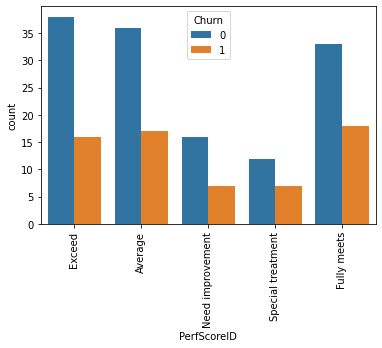

In [17]:
# Proporsi churn berdasarkan 'PerfScoreID'
sns.countplot(data = data_train,
              x = 'PerfScoreID',
              hue = 'Churn')
plt.xticks(rotation=90)

In [21]:
# Independence test
independence_test('PerfScoreID')

Churn and PerfScoreID is independent with P-val=0.9634331190078695.


**Summay:**


Berdasarkan independence test, pegawai resign dan penilaian pegawai merupakan **independent**.

In [22]:
# Cek missing value
data_train['PerfScoreID'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `PerfScoreID`.
- Karena tipe data ordinal, maka perlu ditransformasi menjadi numerik yaitu Special treatment (1), Need improvement (2), Average (3). Fully meets (4), dan Exceed (5)

## Predictor 3: EngagementSurvey       

---
Engagement Survey pegawai

In [23]:
# Statistik deskriptif EngagementSurvey
data_train['EngagementSurvey'].describe()

count    200.000000
mean       4.150800
std        0.781713
min        1.200000
25%        3.730000
50%        4.300000
75%        4.737500
max        5.000000
Name: EngagementSurvey, dtype: float64

<AxesSubplot:xlabel='EngagementSurvey', ylabel='Count'>

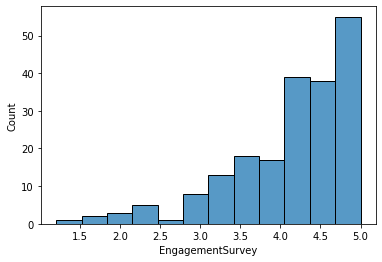

In [24]:
# Distribusi EngagementSurvey
sns.histplot(data = data_train,
             x = 'EngagementSurvey')

In [25]:
# Statistik deskriptif EngagementSurvey berdasarkan churn
data_train['EngagementSurvey'].groupby(data_train['Churn']).describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,135.0,4.157556,0.781577,1.2,3.765,4.3,4.715,5.0
1,65.0,4.136769,0.787891,2.0,3.720,4.2,4.760,5.0


<AxesSubplot:xlabel='Churn', ylabel='EngagementSurvey'>

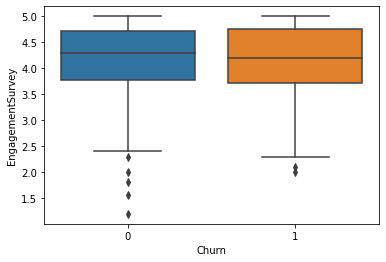

In [26]:
# Boxplot EngagementSurvey berdasarkan churn
sns.boxplot(data = data_train,
            x = 'Churn',
            y = 'EngagementSurvey')

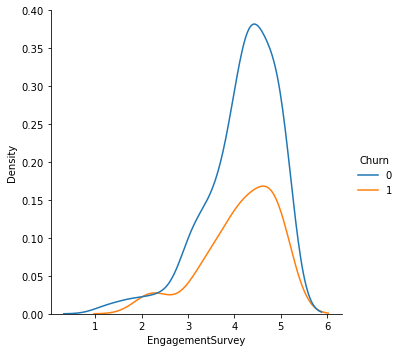

In [27]:
# Distribusi EngagementSurvey berdasarkan churn
sns.displot(data = data_train,
            x = 'EngagementSurvey',
            hue = 'Churn',
            kind = 'kde')

**Summay:**


EngagementSurvey pada pegawai yang resign dan yang tidak resign memiliki distribusi yang sama, yaitu meningkat pada score 3 hingga 4.5

In [28]:
# Cek missing value
data_train['EngagementSurvey'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `EngagementSurvey`.

## Predictor 4: EmpSatisfaction       

---
Tingkat kepuasan kerja pegawai

In [29]:
# Proporsi 'EmpSatisfaction'
data_train['EmpSatisfaction'].value_counts(normalize=True)

5    0.355
3    0.325
4    0.305
2    0.010
1    0.005
Name: EmpSatisfaction, dtype: float64

<AxesSubplot:xlabel='EmpSatisfaction', ylabel='count'>

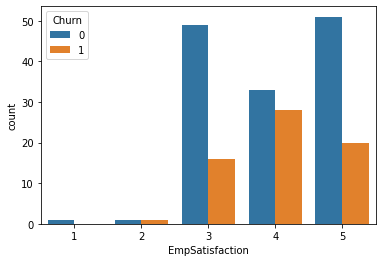

In [30]:
# Proporsi churn berdasarkan 'EmpSatisfaction'
sns.countplot(data = data_train,
              x = 'EmpSatisfaction',
              hue = 'Churn')

In [31]:
# Independence test
independence_test('EmpSatisfaction')

Churn and EmpSatisfaction is independent with P-val=0.08438935561958837.


**Summay:**


Berdasarkan independence test, pegawai resign dan tingkat kepuasan kerja pegawai merupakan **independent**.

In [32]:
# Cek missing value
data_train['EmpSatisfaction'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `EmpSatisfaction`.

## Predictor 5: SpecialProjectsCount       

---
Jumlah special projects yang dikerjakan pegawai

In [33]:
# Statistik deskriptif SpecialProjectsCount
data_train['SpecialProjectsCount'].describe()

count    200.000000
mean       1.200000
std        2.314473
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        8.000000
Name: SpecialProjectsCount, dtype: float64

<AxesSubplot:xlabel='SpecialProjectsCount', ylabel='Count'>

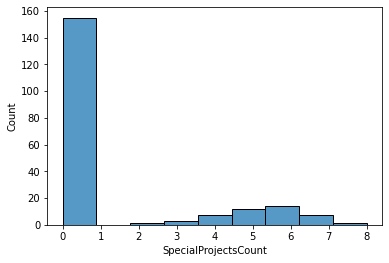

In [34]:
# Distribusi SpecialProjectsCount
sns.histplot(data = data_train,
             x = 'SpecialProjectsCount')

In [35]:
# Statistik deskriptif SpecialProjectsCount berdasarkan churn
data_train['SpecialProjectsCount'].groupby(data_train['Churn']).describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,135.0,1.451852,2.502889,0.0,0.0,0.0,3.0,8.0
1,65.0,0.676923,1.768719,0.0,0.0,0.0,0.0,7.0


<AxesSubplot:xlabel='Churn', ylabel='SpecialProjectsCount'>

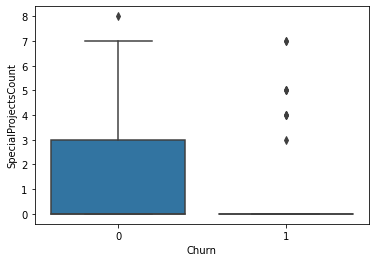

In [36]:
# Boxplot SpecialProjectsCount berdasarkan churn
sns.boxplot(data = data_train,
            x = 'Churn',
            y = 'SpecialProjectsCount')

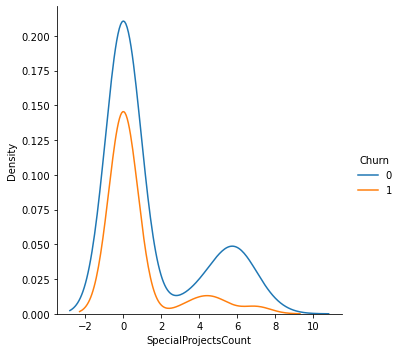

In [37]:
# Distribusi SpecialProjectsCount berdasarkan churn
sns.displot(data = data_train,
            x = 'SpecialProjectsCount',
            hue = 'Churn',
            kind = 'kde')

**Summay:**


Jumlah special projects yang dikerjakan pegawai yang resign berada pada niai 0 dan diatas 3. Hal ini bisa menjadi penyebab karyawan resign karena tidak menangani project apapun atau menangani project terlalu banyak.

In [38]:
# Cek missing value
data_train['SpecialProjectsCount'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `SpecialProjectsCount`.

## Predictor 6: DaysLateLast30       

---
Jumlah hari keterlambatan masuk kerja pegawai dalam waktu 30 hari terakhir

In [39]:
# Statistik deskriptif DaysLateLast30
data_train['DaysLateLast30'].describe()

count    200.00000
mean       0.31500
std        1.08242
min        0.00000
25%        0.00000
50%        0.00000
75%        0.00000
max        6.00000
Name: DaysLateLast30, dtype: float64

<AxesSubplot:xlabel='DaysLateLast30', ylabel='Count'>

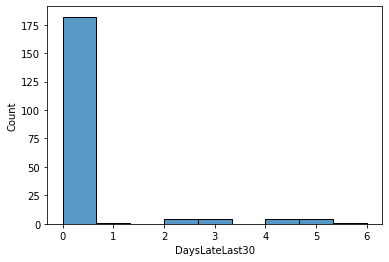

In [40]:
# Distribusi DaysLateLast30
sns.histplot(data = data_train,
             x = 'DaysLateLast30')

In [41]:
# Statistik deskriptif DaysLateLast30 berdasarkan churn
data_train['DaysLateLast30'].groupby(data_train['Churn']).describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,135.0,0.185185,0.821222,0.0,0.0,0.0,0.0,6.0
1,65.0,0.584615,1.456583,0.0,0.0,0.0,0.0,5.0


<AxesSubplot:xlabel='Churn', ylabel='DaysLateLast30'>

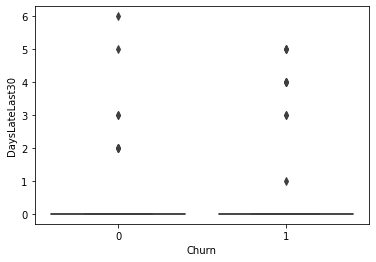

In [42]:
# Boxplot DaysLateLast30 berdasarkan churn
sns.boxplot(data = data_train,
            x = 'Churn',
            y = 'DaysLateLast30')

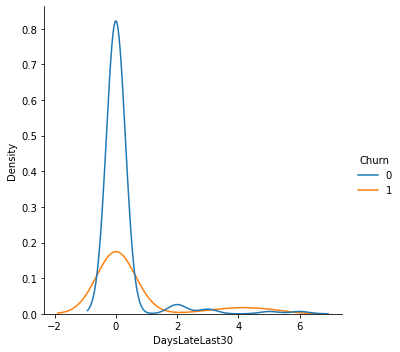

In [43]:
# Distribusi DaysLateLast30 berdasarkan churn
sns.displot(data = data_train,
            x = 'DaysLateLast30',
            hue = 'Churn',
            kind = 'kde')

**Summay:**


Jumlah keterlambatan dalam 30 hari terakhir pegawai yang resign dan yang tidak resign memiliki distribusi yang sama, yaitu tinggi pada pegawai yang tidak pernah telat dalam kurun waktu 30 tahun terakhir.

In [44]:
# Cek missing value
data_train['DaysLateLast30'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `DaysLateLast30`.

## Predictor 7: Absences       

---
Jumlah ketidakhadiran kerja pegawai

In [45]:
# Statistik deskriptif Absences
data_train['Absences'].describe()

count    200.00000
mean      10.32500
std        5.98905
min        1.00000
25%        4.75000
50%       11.00000
75%       16.00000
max       20.00000
Name: Absences, dtype: float64

<AxesSubplot:xlabel='Absences', ylabel='Count'>

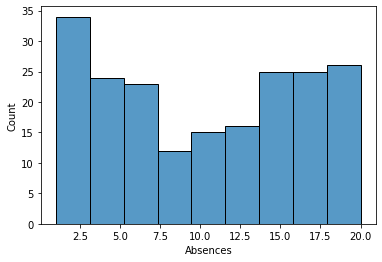

In [46]:
# Distribusi Absences
sns.histplot(data = data_train,
             x = 'Absences')

In [47]:
# Statistik deskriptif Absences berdasarkan churn
data_train['Absences'].groupby(data_train['Churn']).describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,135.0,9.570370,5.867366,1.0,4.0,9.0,15.0,20.0
1,65.0,11.892308,5.979452,1.0,7.0,13.0,17.0,20.0


<AxesSubplot:xlabel='Churn', ylabel='Absences'>

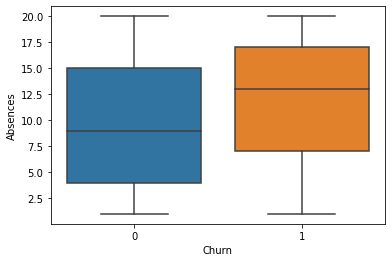

In [48]:
# Boxplot Absences berdasarkan churn
sns.boxplot(data = data_train,
            x = 'Churn',
            y = 'Absences')

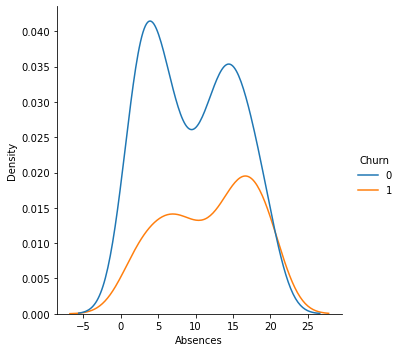

In [49]:
# Distribusi Absences berdasarkan churn
sns.displot(data = data_train,
            x = 'Absences',
            hue = 'Churn',
            kind = 'kde')

**Summay:**


Distribusi jumlah ketidakhadiran pegawai yang resign meningkat pada 7 hingga 17. Hal ini bisa menjadi indikasi pegawai resign akan memiliki banyak absen.

In [50]:
# Cek missing value
data_train['Absences'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `Absences`.

## Predictor 8: Age       

---
Umur pegawai

In [51]:
# Statistik deskriptif Age
data_train['Age'].describe()

count    200.000000
mean      41.300000
std        8.337721
min       28.000000
25%       35.000000
50%       40.000000
75%       47.000000
max       70.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Count'>

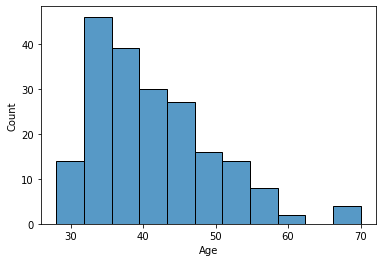

In [52]:
# Distribusi Age
sns.histplot(data = data_train,
             x = 'Age')

In [53]:
# Statistik deskriptif Age berdasarkan churn
data_train['Age'].groupby(data_train['Churn']).describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,135.0,40.740741,8.157007,28.0,34.0,39.0,45.5,70.0
1,65.0,42.461538,8.649561,29.0,36.0,42.0,48.0,69.0


<AxesSubplot:xlabel='Churn', ylabel='Age'>

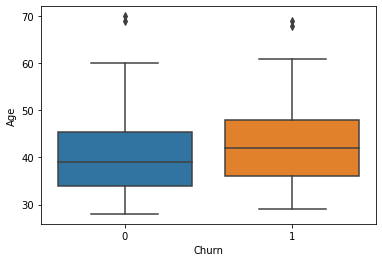

In [54]:
# Boxplot Age berdasarkan churn
sns.boxplot(data = data_train,
            x = 'Churn',
            y = 'Age')

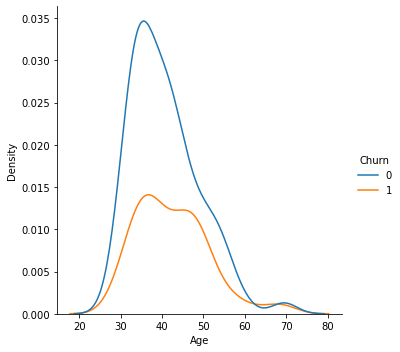

In [55]:
# Distribusi Age berdasarkan churn
sns.displot(data = data_train,
            x = 'Age',
            hue = 'Churn',
            kind = 'kde')

**Summay:**


Umur pegawai yang resign dan yang aktif/tidak resign memiliki distribusi yang sama. Pegawai yang resign meningkat pada rentang umur 35 hingga 48 tahun.

In [56]:
# Cek missing value
data_train['Age'].isnull().any()

False

**Pre-processing Plan:**
- Tidak ada outlier dan missing values dari `Age`.

# Pre-processing
---

## Make Dummies
---

Berdasarkan EDA, ada 3 prediktor kategorik yaitu `LevelID`, `PerfScoreID` , dan `EmpSatisfaction`. Prediktor `EmpSatisfaction` sudah menjadi ordinal dalam bentuk angka. Sedangkan prediktor `LevelID` dan  `PerfScoreID` harus dilakukan transformasi. Kedua prediktor tersebut ordinal. Sehingga, transformasi kategorik menjadi numerik diurutkan dari level terendah hingga level tertinggi.

In [57]:
# Dict LevelID
level = {
    "Junior" : 1,
    "Middle": 2, 
    "Senior": 3
}

# Dict PerfScoreID
perf = {
    "Special treatment" : 1,
    "Need improvement": 2,
    "Average": 3,
    "Fully meets": 4,
    "Exceed": 5
}
 
# Transformasi kategorik menjadi numerik pada data Train
data_train['LevelID'] = data_train['LevelID'].map(level)
data_train['PerfScoreID'] = data_train['PerfScoreID'].map(perf)

# Transformasi kategorik menjadi numerik pada data Test
X_test['LevelID'] = X_test['LevelID'].map(level)
X_test['PerfScoreID'] = X_test['PerfScoreID'].map(perf)

## Data Balancing - Random Oversampling (ROS)
---

In [58]:
# Cek training set
print('data_train old shape:', data_train.shape)

data_train old shape: (200, 9)


In [59]:
# Cek jumlah variabel Respon
data_train['Churn'].value_counts()

0    135
1     65
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

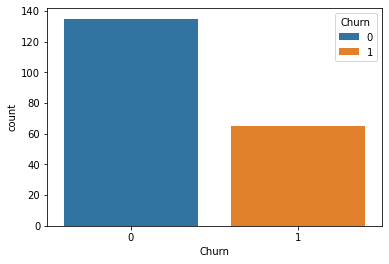

In [60]:
# Cek proporsi sebelum balancing
sns.countplot(data = data_train,
              x = 'Churn',
              hue = 'Churn',
              dodge = False)

Mempertimbangkan dataset yang kecil, maka teknik balancing yang digunakan yaitu ***Random Oversampling (ROS)***

In [61]:
def ros_fit_resample(data_train: pd.DataFrame, response_variable) -> pd.DataFrame:

    # Create copy of set data
    data_train = data_train.copy()

    # Create sampling object
    ros = RandomOverSampler(random_state = 42)

    # Balancing data set
    x_ros, y_ros = ros.fit_resample(data_train.drop([response_variable], axis = 1),
                                    data_train[response_variable])

    # Concatenate balanced data set
    data_train_ros = pd.concat([x_ros, y_ros], axis = 1)

    # Return balanced data set
    return data_train_ros

In [62]:
# Perform ROS
data_train_ros = ros_fit_resample(data_train = data_train,
                                  response_variable = 'Churn')

<AxesSubplot:xlabel='Churn', ylabel='count'>

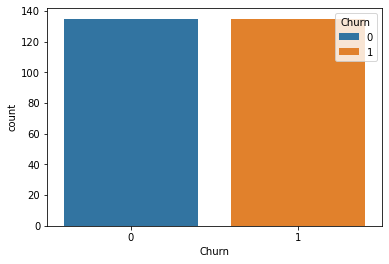

In [63]:
# Cek proporsi pada kategori respon
sns.countplot(data = data_train_ros,
              x = 'Churn',
              hue = 'Churn',
              dodge = False)

In [64]:
# Cek balanced response
data_train_ros['Churn'].value_counts()

0    135
1    135
Name: Churn, dtype: int64

# Model Selection

In [65]:
def AIC(y_true, y_pred, p):
    """
    Function to split sample with validation set approach.

    Parameters
    ----------
    y_true : {array-like} of shape (n_sample, )
        Actual value of response variable.

    y_pred : {array-like} of shape (n_sample, 1)
        The success probability of X.

    p : int
        Number of parameters in model.

    Returns
    -------
    aic : float
        AIC value.
    """
    # Find the average log likelihood value
    llf = np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    # AIC value is sensitive to number of parameters
    # The average log likelihood represent value for 1 unit observation
    # AIC from average llf is not comparable
    # Multiply llf by n_sample=173 to make its AIC comparable
    llf *= data_train.shape[0]

    # Calculate AIC
    aic = -2 * (llf - p)

    return aic

In [66]:
def kfold_split(X, k=5, random_state=42):
    """
    Function to split sample with validation set approach.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        All predictors set.

    k : int, default = 5
        Number of folds.

    random_state : int
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    train_ind_list : list
        Contains data index of train set.

    valid_ind_list : list
        Contains data index of validation set.
    """
    # Extract sample size
    n_samples, _ = X.shape

    # Set random state
    np.random.seed(random_state)

    # # Randomize index
    random_ind = np.random.choice(n_samples,
                                  size = n_samples,
                                  replace = False)

    # Calculate size of each fold
    fold_sizes = np.ones(k, dtype=int) * (n_samples//k)
    fold_sizes[:n_samples%k] += 1

    # Define initial list for each train and valid index
    train_ind_list = []
    valid_ind_list = []

    # Split sample
    current_ind = 0
    for size in fold_sizes:
        # Define index
        start_ind = current_ind
        end_ind = current_ind + size

        # Slice valid set
        # One fold for valid set, the remaining for train set
        valid_ind = random_ind[start_ind:end_ind]
        train_ind = np.concatenate((random_ind[:start_ind],
                                    random_ind[end_ind:]))

        # Update current index
        current_ind = end_ind

        # Append train and valid index in list
        train_ind_list.append(train_ind)
        valid_ind_list.append(valid_ind)

    return train_ind_list, valid_ind_list

In [67]:
def cross_validate(X, y, method, cv, random_state=42):
    """
    Function to evaluate AIC by cross-validation method.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        The independent variable or predictors.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.

    method : cross-validation splitter
        Cross-validation method.

    cv : int
        Number of folds for k-Fold CV.

    random_state : int, default=42
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    score : float
        The average AIC score.
    """
    # Split train and valid set based on CV method
    if method == "validation_set":
        train_ind_list, valid_ind_list = validation_set_split(X = X,
                                                              random_state = random_state)
    elif method == "loocv":
        train_ind_list, valid_ind_list = loocv_split(X = X)
    elif method == "kfold":
        train_ind_list, valid_ind_list = kfold_split(X = X,
                                                     k = cv,
                                                     random_state = random_state)

    # Define the number of train sets
    n_split = len(train_ind_list)

    # Initialize AIC score list for each valid set
    score_list = []

    for i in range(n_split):
        # Extract data from index
        X_train = X[train_ind_list[i]]
        y_train = y[train_ind_list[i]]
        X_valid = X[valid_ind_list[i]]
        y_valid = y[valid_ind_list[i]]

        # Add constant
        X_train = sm.add_constant(X_train, has_constant="add")
        X_valid = sm.add_constant(X_valid, has_constant="add")

        # Fitting model
        model = sm.Logit(y_train, X_train)
        results = model.fit(disp=False)

        # Calculate success probability
        y_pred_train = results.predict(X_train)
        y_pred_valid = results.predict(X_valid)

        # Calculate AIC
        aic_train = AIC(y_true = y_train,
                        y_pred = y_pred_train,
                        p = X_train.shape[1])
        aic_valid = AIC(y_true = y_valid,
                        y_pred = y_pred_valid,
                        p = X_train.shape[1])

        # Append AIC score in list
        score_list.append(aic_valid)

    # Calculate CV Score
    score = np.mean(score_list)

    return score

In [68]:
def forward(X, y, predictors, method, cv=5, random_state=42):
    """
    Function to perform best subset selection procedure.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        All predictors set.

    y : {array-like} of shape (n_sample, )
        The dependent or response variable.

    predictors : {array-like} of shape (n_sample, )
        Index of predictors

    method : cross-validation splitter
        Cross-validation method.

    cv : int, default=5
        Number of folds for k-Fold CV.

    random_state : int, default=42
        Pass an int for reproducible output across multiple function calls.

    Returns
    -------
    models : {array-like} of shape (n_combinations, k)
        Summary of predictors and its AIC score for each possible combination.

    best_model : {array-like} of shape (2, )
        Best model of models with the smallest AIC score.
    """

    # Initialize list of results
    results = []

    # Define sample size and  number of all predictors
    n_samples, n_predictors = X.shape

    # Define list of all predictors
    col_list = np.arange(n_predictors)

    # Define remaining predictors for each k
    remaining_predictors = [p for p in col_list if p not in predictors]

    # Initialize list of predictors and its CV Score
    pred_list = []
    score_list = []

    # Cross validate each possible combination of remaining predictors
    for p in remaining_predictors:
        combi = predictors + [p]

        # Extract predictors combination
        X_ = X[:, combi]
        y_ = y

        # Cross validate to get CV Score
        score_ = cross_validate(X = X_,
                                y = y_,
                                method = method,
                                cv = cv,
                                random_state = random_state)

        # Append predictors combination and its CV Score to the list
        pred_list.append(list(combi))
        score_list.append(score_)

    # Tabulate the results
    models = pd.DataFrame({"Predictors": pred_list,
                            "AIC": score_list})

    # Choose the best model
    best_model = models.loc[models["AIC"].argmin()]

    return models, best_model

## The Original Training Set
---

In [69]:
# Split respon and prediktor
y_train = data_train['Churn']
X_train = data_train.drop(columns=['Churn'], axis=1)

# Convert dataframe ke numpy
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (200, 8)
y_train shape: (200,)


In [70]:
# Fit null model
predictor = []
score_ = cross_validate(X = X_train[:, predictor],
                        y = y_train,
                        method = 'kfold',
                        cv = 5,
                        random_state = 42)

# Mendefinisakan tabel untuk best model untuk setiap k prediktor
forward_models = pd.DataFrame({"Predictors": [predictor],
                               "AIC": [score_]})

forward_models

,Predictors,AIC
0,[],255.626413


In [71]:
# Definisikan list prediktor
predictors = []
n_predictors = X_train.shape[1]

# Teknik forward selection untuk k=1,...,9 prediktor
for k in range(n_predictors):
    _, best_model = forward(X = X_train,
                            y = y_train,
                            predictors = predictors,
                            method = "kfold",
                            cv = 5,
                            random_state = 42)

    # Tabulasi best model pada masing-masing k prediktor 
    forward_models.loc[k+1] = best_model
    predictors = best_model["Predictors"]

In [72]:
# Best model pada masing-masing k prediktor
forward_models

,Predictors,AIC
0,[],255.626413
1,[6],252.924185
2,"[6, 5]",250.872492
3,"[6, 5, 4]",250.003255
4,"[6, 5, 4, 0]",250.284722
5,"[6, 5, 4, 0, 7]",251.646592
6,"[6, 5, 4, 0, 7, 3]",253.505930
7,"[6, 5, 4, 0, 7, 3, 1]",259.264685
8,"[6, 5, 4, 0, 7, 3, 1, 2]",266.802884


In [73]:
# Best AIC score
best_idx = forward_models['AIC'].argmin()
best_AIC = forward_models['AIC'].loc[best_idx]
best_predictors = forward_models['Predictors'].loc[best_idx]

print('Best index            :', best_idx)
print('Best AIC              :', best_AIC)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(data_train.columns[best_predictors].tolist())

Best index            : 3
Best AIC              : 250.003255366335
Best predictors (idx) : [6, 5, 4]
Best predictors       :
['Absences', 'DaysLateLast30', 'SpecialProjectsCount']


In [74]:
# Best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
X_train_best = sm.add_constant(X_train_best)
best_model_ori = sm.Logit(y_train, X_train_best)
best_model_ori_result = best_model_ori.fit()

print(best_model_ori_result.summary())

Optimization terminated successfully.
         Current function value: 0.589905
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:                 0.06451
Time:                        08:59:00   Log-Likelihood:                -117.98
converged:                       True   LL-Null:                       -126.12
Covariance Type:            nonrobust   LLR p-value:                 0.0009981
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3666      0.348     -3.929      0.000      -2.048      -0.685
x1             0.0643      0.

In [75]:
# Extract AIC
best_model_ori_result.aic

243.9620970267608

In [76]:
# Estimasi parameter pada best model
best_model_ori_params = ['constant'] + data_train.columns[best_predictors].tolist()
best_model_ori_summary = pd.DataFrame({
                                    'weights': best_model_ori_result.params,
                                    'OR': np.exp(best_model_ori_result.params)
                                  },
                                  index = best_model_ori_params)

best_model_ori_summary

,weights,OR
constant,-1.366571,0.254980
Absences,0.064294,1.066406
DaysLateLast30,0.299924,1.349756
SpecialProjectsCount,-0.153501,0.857700


## ROS Training Set
---

In [77]:
# Split respon and prediktor
y_train_ros = data_train_ros['Churn']
X_train_ros = data_train_ros.drop(columns=['Churn'], axis=1)

# Convert dataframe ke numpy
X_train_ros = X_train_ros.to_numpy()
y_train_ros = y_train_ros.to_numpy()

print('y_train_ros shape :', y_train_ros.shape)
print('X_train_ros shape :', X_train_ros.shape)

y_train_ros shape : (270,)
X_train_ros shape : (270, 8)


In [78]:
# Fit null model
predictor = []
score_ = cross_validate(X = X_train_ros[:, [1]],
                        y = y_train_ros,
                        method = 'kfold',
                        cv = 5,
                        random_state = 42)

# Mendefinisakan tabel untuk best model untuk setiap k prediktor
forward_models_ros = pd.DataFrame({"Predictors": [predictor],
                                   "AIC": [score_]})

forward_models_ros

,Predictors,AIC
0,[],284.250045


In [79]:
# Definisikan list prediktor
predictors = []
n_predictors = X_train_ros.shape[1]

# Teknik forward selection untuk k=1,...,9 prediktor
for k in range(n_predictors):
    _, best_model = forward(X = X_train_ros,
                            y = y_train_ros,
                            predictors = predictors,
                            method = "kfold",
                            cv = 5,
                            random_state = 42)

    # Tabulasi best model pada masing-masing k prediktor 
    forward_models_ros.loc[k+1] = best_model
    predictors = best_model["Predictors"]

In [80]:
# Best model pada masing-masing k prediktor
forward_models_ros

,Predictors,AIC
0,[],284.250045
1,[6],279.568664
2,"[6, 5]",279.460501
3,"[6, 5, 7]",278.482963
4,"[6, 5, 7, 0]",278.559254
5,"[6, 5, 7, 0, 4]",280.989833
6,"[6, 5, 7, 0, 4, 3]",283.875264
7,"[6, 5, 7, 0, 4, 3, 2]",287.491838
8,"[6, 5, 7, 0, 4, 3, 2, 1]",290.997391


In [81]:
# Best AIC score
best_idx_ros = forward_models_ros['AIC'].argmin()
best_AIC_ros = forward_models_ros['AIC'].loc[best_idx_ros]
best_predictors_ros = forward_models_ros['Predictors'].loc[best_idx_ros]

print('Best index            :', best_idx_ros)
print('Best AIC              :', best_AIC_ros)
print('Best predictors (idx) :', best_predictors_ros)
print('Best predictors       :')
print(data_train_ros.columns[best_predictors_ros].tolist())

Best index            : 3
Best AIC              : 278.4829633532278
Best predictors (idx) : [6, 5, 7]
Best predictors       :
['Absences', 'DaysLateLast30', 'Age']


In [82]:
# Best predictors
X_train_ros_best = X_train_ros[:, best_predictors_ros]

# Fit best model
X_train_ros_best = sm.add_constant(X_train_ros_best)
best_model_ros = sm.Logit(y_train_ros, X_train_ros_best)
best_model_ros_result = best_model_ros.fit()

print(best_model_ros_result.summary())

Optimization terminated successfully.
         Current function value: 0.664144
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  270
Model:                          Logit   Df Residuals:                      266
Method:                           MLE   Df Model:                            3
Date:                Sun, 29 Oct 2023   Pseudo R-squ.:                 0.04184
Time:                        08:59:00   Log-Likelihood:                -179.32
converged:                       True   LL-Null:                       -187.15
Covariance Type:            nonrobust   LLR p-value:                  0.001330
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0018      0.693     -2.888      0.004      -3.360      -0.643
x1             0.0459      0.

In [83]:
# Extract AIC
best_model_ros_result.aic

366.6375613709759

In [84]:
# Estimasi parameter pada best model
best_model_ros_params = ['constant'] + data_train_ros.columns[best_predictors_ros].tolist()
best_model_ros_summary = pd.DataFrame({
                                    'weights': best_model_ros_result.params,
                                    'OR': np.exp(best_model_ros_result.params)
                                  },
                                  index = best_model_ros_params)

best_model_ros_summary

,weights,OR
constant,-2.001830,0.135088
Absences,0.045887,1.046956
DaysLateLast30,0.318622,1.375232
Age,0.034134,1.034724


# Model Evaluation
---

In [85]:
def predictive_performance(X_test, y_test, model, predictors):

    # Calculate success probability
    X_test_best = X_test[:, predictors]
    X_test_sm = sm.add_constant(X_test_best)
    y_pred_test = model.predict(X_test_sm)

    # Calculate AIC
    aic_test = AIC(y_true = y_test,
                 y_pred = y_pred_test,
                 p = X_test.shape[1]+1)

    # Calculate AUC
    auc = metrics.roc_auc_score(y_true = y_test,
                              y_score = y_pred_test)

    return y_pred_test, round(aic_test, 2), round(auc, 2)

In [86]:
# Convert data Test ke NumPy
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X test shape: (87, 8)
y test shape: (87,)


## The Original Training Set
---

In [87]:
# Menghitung performa Original Model
y_pred_test, aic_test, auc = predictive_performance(X_test = X_test,
                                                    y_test = y_test,
                                                    model = best_model_ori_result,
                                                    predictors = best_predictors)

# Summarize dalam bentuk tabel
model_eval = pd.Series({'Method': 'Original',
                        'Predictors' : best_predictors,
                        'AIC Valid' : best_AIC,
                        'AIC Test' : aic_test,
                        'AUC' : auc})

model_eval = model_eval.to_frame()
model_eval

,0
Method,Original
Predictors,"[6, 5, 4]"
AIC Valid,250.003255
AIC Test,287.76
AUC,0.5


<AxesSubplot:ylabel='Count'>

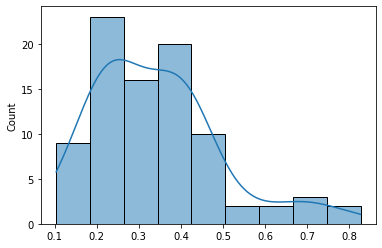

In [88]:
# Distribusi predicted probability
sns.histplot(x = y_pred_test,
             kde = True)

## ROS Training Set
---

In [89]:
# Menghitung performa ROS Model
y_pred_test_ros, aic_test_ros, auc_ros = predictive_performance(X_test = X_test,
                                                                y_test = y_test,
                                                                model = best_model_ros_result,
                                                                predictors = best_predictors_ros)

# Summarize dalam bentuk tabel
ros_eval = pd.Series({'Method': 'Oversampling',
                        'Predictors' : best_predictors_ros,
                        'AIC Valid' : best_AIC_ros,
                        'AIC Test' : aic_test_ros,
                        'AUC' : auc_ros})

# Concat dengan model_eval
model_eval = pd.concat([model_eval, ros_eval],
                       axis=1,
                       ignore_index=True)
model_eval.T

,Method,Predictors,AIC Valid,AIC Test,AUC
0,Original,"[6, 5, 4]",250.003255,287.76,0.5
1,Oversampling,"[6, 5, 7]",278.482963,320.08,0.51


<AxesSubplot:ylabel='Count'>

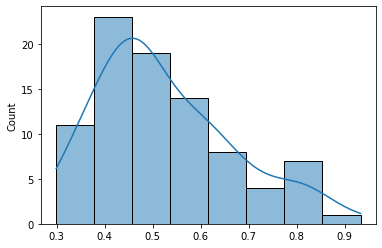

In [90]:
# Distribusi predicted probability
sns.histplot(x = y_pred_test_ros,
             kde = True)

# Interpret the Best Model Parameters
---

**Summary:**
- Best model yaitu model dengan data training Original karena memiliki AIC terkecil pada data validation dan test.
- Namun model dengan data original kesulitan untuk memprediksi `y=1` saat cut-off probability 0.5.
- AUC pada training set original dan ROS hampir mirip, disebabkan  imbalanced data set 

In [91]:
best_model_ori_summary

,weights,OR
constant,-1.366571,0.254980
Absences,0.064294,1.066406
DaysLateLast30,0.299924,1.349756
SpecialProjectsCount,-0.153501,0.857700


- **Prediktor yang meningkatkan resign pegawai** :
    - `Absences` : peningkatan 1 hari absences akan meningkatkan odds of churning hampir 7%
    - `DaysLateLast30` : peningkatan 1 kali telat akan meningkatkan odds of churning hampit 35%

- **Prediktor yang menurunkan resign pegawai** :
    - `SpecialProjectsCount` : peningkatan 1 project akan menurunkan odds of churning hampir 15%